In [41]:
from transformers import BertConfig, BertModel, AutoTokenizer, TrainingArguments, AutoModelForSequenceClassification, Trainer, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

import matplotlib.pyplot as plt
from collections import Counter


In [42]:
torch.cuda.is_available()

True

In [43]:
tokenizer = AutoTokenizer.from_pretrained("TurkuNLP/bert-base-finnish-cased-v1")

In [44]:
# Loading dataset
dataSetPath = "yle_data/2011-2018-SubjectsInPaper-1.csv"
df = pd.read_csv(dataSetPath, sep="␞", nrows=200000)


print(df['text'].isna().sum(), "invalid data")
df = df.dropna(subset=['text'])
print(len(df), "valid data")

print(df.columns)
df = df.drop(['id', 'url', 'headline', 'datePublished'], axis=1) 


def multiLabelToSingular(labelArray):
    cleaned_text = labelArray.replace("'", "").replace(" ", "").replace("[", "").replace("]", "")
    return cleaned_text.split(",")[0]


# print(df.dtypes)
df['subjects'] = df['subjects'].apply(multiLabelToSingular)

print(df['subjects'].nunique(), "categories")
print(df['subjects'].unique().tolist())

df.rename({'subjects': 'labels'}, axis="columns", inplace=True)



C:\Users\joakim\AppData\Local\Temp\ipykernel_19116\3043923669.py:3: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(dataSetPath, sep="␞", nrows=200000)


612 invalid data
199388 valid data
Index(['id', 'url', 'headline', 'text', 'subjects', 'datePublished'], dtype='object')
10 categories
['urheilu', 'kulttuuri', 'talous', 'luonto', 'Onnettomuudet', 'politiikka', 'Rikokset', 'Liikenne_ja_kuljetus', 'Koulutus_ja_kasvatus', 'Terveys']


In [45]:
# paperin luokat:

# urheilu "18-220090",
# talous "18-204933",
# politiikka "18-220306",
# kulttuuri "18-208149",
# luonto "18-215452",
# 18-218480 - Onnettomuudet
# 18-209306 - Terveys
# 18-217206 - Rikokset
# 18-91232 - Liikenne ja kuljetus
# 18-35286 - Koulutus ja kasvatus

label_mapping = {
    "Koulutus_ja_kasvatus": 0,
    "Liikenne_ja_kuljetus": 1,
    "Onnettomuudet": 2,
    "Rikokset": 3,
    "Terveys": 4,
    "kulttuuri": 5,
    "luonto": 6,
    "politiikka": 7,
    "talous": 8,
    "urheilu": 9
}

to_labels = {y: x for x, y in label_mapping.items()}

print(df['labels'].value_counts().sort_index(ascending=True))
df["labels"] = df["labels"].map(label_mapping)
print(df['labels'].value_counts().sort_index(ascending=True))


Koulutus_ja_kasvatus    10753
Liikenne_ja_kuljetus    13554
Onnettomuudet           10717
Rikokset                 8166
Terveys                  8600
kulttuuri               13794
luonto                  10994
politiikka              12961
talous                  24427
urheilu                 85422
Name: labels, dtype: int64
0    10753
1    13554
2    10717
3     8166
4     8600
5    13794
6    10994
7    12961
8    24427
9    85422
Name: labels, dtype: int64


In [46]:
n_sample = 250 # 250
# df_balanced = df.groupby('labels').head(n_sample)
df_balanced = df.groupby('labels').apply(lambda x: x.sample(n=n_sample))

print(len(df_balanced), "documents")
print(df_balanced['labels'].value_counts().sort_index(ascending=True))


2500 documents
0    250
1    250
2    250
3    250
4    250
5    250
6    250
7    250
8    250
9    250
Name: labels, dtype: int64


In [47]:
dataset = Dataset.from_pandas(df_balanced, preserve_index=False)
dataset

Dataset({
    features: ['text', 'labels'],
    num_rows: 2500
})

In [48]:

train_test_split = dataset.train_test_split(test_size=0.2)

train_valid_split = train_test_split['train'].train_test_split(test_size=0.1)

datasets = DatasetDict({
    'train': train_valid_split['train'],
    'validation': train_valid_split['test'],
    'test': train_test_split['test']
})
print(datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 1800
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 500
    })
})


In [49]:
unique_values = set(datasets["train"]["labels"])
print(unique_values)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [50]:
def tokenize_function(example):
    tokenized = tokenizer(example["text"], truncation=True)
    return tokenized

In [51]:

tokenized_datasets = datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_datasets



Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1800
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [52]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "f1": f1}

training_args = TrainingArguments(
    output_dir="./logs",                    
    evaluation_strategy="steps",        
    eval_steps=50,                      
    logging_dir="./logs",                
    logging_steps=50,                   
    save_steps=500,                      
    per_device_train_batch_size=8,       
    per_device_eval_batch_size=16,       
    num_train_epochs=5,                  
    save_total_limit=2,                  
    load_best_model_at_end=True,         
    metric_for_best_model="f1",          
    greater_is_better=True,              
    report_to="tensorboard",            
)





In [53]:
model = AutoModelForSequenceClassification.from_pretrained("TurkuNLP/bert-base-finnish-cased-v1", num_labels=10, device_map = 'cuda')


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\joakim\anaconda3\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


In [54]:
trainer.train()

  0%|          | 0/1125 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.4901, 'learning_rate': 4.7777777777777784e-05, 'epoch': 0.22}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.908212423324585, 'eval_accuracy': 0.745, 'eval_f1': 0.7405830134273834, 'eval_runtime': 47.3067, 'eval_samples_per_second': 4.228, 'eval_steps_per_second': 0.275, 'epoch': 0.22}
{'loss': 0.8262, 'learning_rate': 4.555555555555556e-05, 'epoch': 0.44}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7022817730903625, 'eval_accuracy': 0.78, 'eval_f1': 0.7763620768457057, 'eval_runtime': 46.9895, 'eval_samples_per_second': 4.256, 'eval_steps_per_second': 0.277, 'epoch': 0.44}
{'loss': 0.5655, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.67}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.655884861946106, 'eval_accuracy': 0.81, 'eval_f1': 0.8103821478539376, 'eval_runtime': 64.2869, 'eval_samples_per_second': 3.111, 'eval_steps_per_second': 0.202, 'epoch': 0.67}
{'loss': 0.6022, 'learning_rate': 4.111111111111111e-05, 'epoch': 0.89}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.6563845276832581, 'eval_accuracy': 0.84, 'eval_f1': 0.8391273515463884, 'eval_runtime': 64.2037, 'eval_samples_per_second': 3.115, 'eval_steps_per_second': 0.202, 'epoch': 0.89}
{'loss': 0.3564, 'learning_rate': 3.888888888888889e-05, 'epoch': 1.11}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.8324713110923767, 'eval_accuracy': 0.81, 'eval_f1': 0.8114545886604053, 'eval_runtime': 62.5514, 'eval_samples_per_second': 3.197, 'eval_steps_per_second': 0.208, 'epoch': 1.11}
{'loss': 0.4682, 'learning_rate': 3.6666666666666666e-05, 'epoch': 1.33}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.5766937136650085, 'eval_accuracy': 0.835, 'eval_f1': 0.8347612494307185, 'eval_runtime': 62.9914, 'eval_samples_per_second': 3.175, 'eval_steps_per_second': 0.206, 'epoch': 1.33}
{'loss': 0.3168, 'learning_rate': 3.444444444444445e-05, 'epoch': 1.56}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.6756551861763, 'eval_accuracy': 0.85, 'eval_f1': 0.849773372291665, 'eval_runtime': 62.2411, 'eval_samples_per_second': 3.213, 'eval_steps_per_second': 0.209, 'epoch': 1.56}
{'loss': 0.3973, 'learning_rate': 3.222222222222223e-05, 'epoch': 1.78}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7281148433685303, 'eval_accuracy': 0.855, 'eval_f1': 0.8543265115939359, 'eval_runtime': 62.0013, 'eval_samples_per_second': 3.226, 'eval_steps_per_second': 0.21, 'epoch': 1.78}
{'loss': 0.3404, 'learning_rate': 3e-05, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.6632617115974426, 'eval_accuracy': 0.86, 'eval_f1': 0.8604211911197388, 'eval_runtime': 61.8986, 'eval_samples_per_second': 3.231, 'eval_steps_per_second': 0.21, 'epoch': 2.0}
{'loss': 0.1518, 'learning_rate': 2.777777777777778e-05, 'epoch': 2.22}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.6987830996513367, 'eval_accuracy': 0.835, 'eval_f1': 0.8347741392570583, 'eval_runtime': 62.7133, 'eval_samples_per_second': 3.189, 'eval_steps_per_second': 0.207, 'epoch': 2.22}
{'loss': 0.1807, 'learning_rate': 2.5555555555555554e-05, 'epoch': 2.44}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.6358866095542908, 'eval_accuracy': 0.86, 'eval_f1': 0.8603872526712175, 'eval_runtime': 62.95, 'eval_samples_per_second': 3.177, 'eval_steps_per_second': 0.207, 'epoch': 2.44}
{'loss': 0.1818, 'learning_rate': 2.3333333333333336e-05, 'epoch': 2.67}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.6834964156150818, 'eval_accuracy': 0.86, 'eval_f1': 0.8612677310498666, 'eval_runtime': 62.6737, 'eval_samples_per_second': 3.191, 'eval_steps_per_second': 0.207, 'epoch': 2.67}
{'loss': 0.3137, 'learning_rate': 2.111111111111111e-05, 'epoch': 2.89}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7651159167289734, 'eval_accuracy': 0.85, 'eval_f1': 0.8504833783984361, 'eval_runtime': 64.0413, 'eval_samples_per_second': 3.123, 'eval_steps_per_second': 0.203, 'epoch': 2.89}
{'loss': 0.1409, 'learning_rate': 1.888888888888889e-05, 'epoch': 3.11}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.8718729615211487, 'eval_accuracy': 0.835, 'eval_f1': 0.833130552578828, 'eval_runtime': 62.7532, 'eval_samples_per_second': 3.187, 'eval_steps_per_second': 0.207, 'epoch': 3.11}
{'loss': 0.0966, 'learning_rate': 1.6666666666666667e-05, 'epoch': 3.33}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.8386058211326599, 'eval_accuracy': 0.83, 'eval_f1': 0.8307818149835099, 'eval_runtime': 62.5848, 'eval_samples_per_second': 3.196, 'eval_steps_per_second': 0.208, 'epoch': 3.33}
{'loss': 0.0881, 'learning_rate': 1.4444444444444444e-05, 'epoch': 3.56}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7462443709373474, 'eval_accuracy': 0.865, 'eval_f1': 0.8649404258879639, 'eval_runtime': 62.5494, 'eval_samples_per_second': 3.197, 'eval_steps_per_second': 0.208, 'epoch': 3.56}
{'loss': 0.1361, 'learning_rate': 1.2222222222222222e-05, 'epoch': 3.78}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7571852207183838, 'eval_accuracy': 0.86, 'eval_f1': 0.8605204554714149, 'eval_runtime': 61.272, 'eval_samples_per_second': 3.264, 'eval_steps_per_second': 0.212, 'epoch': 3.78}
{'loss': 0.1304, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7622387409210205, 'eval_accuracy': 0.855, 'eval_f1': 0.8546047014560948, 'eval_runtime': 62.6862, 'eval_samples_per_second': 3.19, 'eval_steps_per_second': 0.207, 'epoch': 4.0}
{'loss': 0.1022, 'learning_rate': 7.777777777777777e-06, 'epoch': 4.22}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7325341701507568, 'eval_accuracy': 0.855, 'eval_f1': 0.854038962113689, 'eval_runtime': 62.7714, 'eval_samples_per_second': 3.186, 'eval_steps_per_second': 0.207, 'epoch': 4.22}
{'loss': 0.038, 'learning_rate': 5.555555555555556e-06, 'epoch': 4.44}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7446986436843872, 'eval_accuracy': 0.865, 'eval_f1': 0.865186228865474, 'eval_runtime': 62.5897, 'eval_samples_per_second': 3.195, 'eval_steps_per_second': 0.208, 'epoch': 4.44}
{'loss': 0.0878, 'learning_rate': 3.3333333333333333e-06, 'epoch': 4.67}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7700586915016174, 'eval_accuracy': 0.855, 'eval_f1': 0.8544766651009905, 'eval_runtime': 62.378, 'eval_samples_per_second': 3.206, 'eval_steps_per_second': 0.208, 'epoch': 4.67}
{'loss': 0.0722, 'learning_rate': 1.1111111111111112e-06, 'epoch': 4.89}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7550215125083923, 'eval_accuracy': 0.865, 'eval_f1': 0.8650675589374183, 'eval_runtime': 62.4611, 'eval_samples_per_second': 3.202, 'eval_steps_per_second': 0.208, 'epoch': 4.89}


c:\Users\joakim\anaconda3\lib\site-packages\transformers\trainer.py:2189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location

{'train_runtime': 5221.9873, 'train_samples_per_second': 1.723, 'train_steps_per_second': 0.215, 'train_loss': 0.31501393983099196, 'epoch': 5.0}


TrainOutput(global_step=1125, training_loss=0.31501393983099196, metrics={'train_runtime': 5221.9873, 'train_samples_per_second': 1.723, 'train_steps_per_second': 0.215, 'train_loss': 0.31501393983099196, 'epoch': 5.0})

In [55]:
predictions = trainer.predict(test_dataset=tokenized_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)


  0%|          | 0/32 [00:00<?, ?it/s]

(500, 10) (500,)


In [56]:

preds = np.argmax(predictions.predictions, axis=-1)
print(preds)
print(predictions.label_ids)

accuracy = accuracy_score(predictions.label_ids, preds)
f1 = f1_score(predictions.label_ids, preds, average='weighted')
print("accuracy=" , accuracy, "f1=" , f1)



[1 3 7 4 7 5 3 3 5 6 1 5 2 2 3 2 5 1 2 5 2 9 4 2 4 4 0 7 8 7 3 8 2 8 0 4 9
 2 5 7 2 2 6 2 8 0 3 8 9 2 4 0 6 0 9 9 9 1 2 0 5 2 8 0 4 0 1 9 1 0 2 3 5 4
 7 2 7 0 4 0 9 3 9 5 6 0 9 3 8 6 4 6 4 8 0 2 4 2 2 7 6 0 8 2 5 6 3 8 0 9 3
 0 5 0 9 9 1 5 2 3 4 4 6 2 1 2 2 3 5 4 2 3 1 0 3 3 8 5 2 4 8 2 2 1 8 0 2 0
 6 7 6 6 5 5 1 3 7 0 4 5 7 6 0 7 1 7 3 2 5 4 3 7 4 6 7 1 6 9 8 4 0 6 7 4 3
 0 8 1 8 6 2 0 9 7 9 1 9 9 1 2 8 6 6 6 5 1 7 7 1 4 6 4 5 4 2 2 3 3 2 3 5 3
 3 8 5 4 7 3 0 4 1 0 2 2 5 7 3 6 6 9 9 2 0 1 5 5 3 0 3 7 3 2 7 0 1 2 8 0 8
 6 9 2 9 7 2 5 5 9 3 7 6 0 6 1 0 1 3 3 4 6 0 3 2 0 1 9 0 4 0 8 1 8 4 7 8 3
 6 2 3 1 9 9 6 9 8 5 8 6 0 4 9 6 3 1 2 3 2 4 4 9 2 1 3 7 3 1 2 2 9 6 9 7 1
 7 8 4 4 3 5 5 2 8 0 5 0 6 0 7 3 1 9 0 0 5 3 9 3 5 3 3 4 4 6 3 5 2 1 2 5 7
 5 1 8 3 0 6 0 2 3 1 9 7 4 8 7 6 6 4 2 8 3 2 0 6 3 0 3 0 7 7 7 5 3 2 1 0 0
 1 7 9 7 4 0 9 1 5 4 5 0 9 5 5 6 7 9 9 5 5 0 6 1 1 2 6 6 2 9 1 9 4 7 9 2 1
 9 8 9 8 5 5 5 6 0 8 4 0 4 8 1 2 9 5 1 2 6 6 0 5 5 1 7 1 3 8 5 3 1 4 9 3 0
 4 3 2 8 6 1 5 2 5 4 2 4 

In [57]:
# old
# predictions = preds
# correct_labels = predictions.label_ids

# modern
# predictions_modern = np.array([0,8,6,8,7,7,7,7,8,1,5,5,8,8,7,8,8,0,5,8,8,8,1,3,3,3,0,5,7,7,7,5,8,8,0,0,8,7,8,8,5,1,6,8,8,8,8,3,8,5,8,5,5,1,6,1,1,7,7,7,7,7,5])
# correct_labels_modern = np.array([3,1,3,7,7,7,7,7,8,1,1,5,1,7,7,7,8,7,5,8,8,5,1,8,3,3,0,7,7,7,7,7,8,7,0,7,5,7,8,8,5,8,6,5,8,8,8,7,8,5,1,5,5,1,6,1,8,7,7,7,7,6,8])

# old
prediction_labels = [to_labels[x] for x in preds]
correct_labels = [to_labels[x] for x in predictions.label_ids]

# modern
# predictions_modern = [to_labels[x] for x in predictions_modern]
# correct_labels_modern = [to_labels[x] for x in correct_labels_modern]


['Koulutus_ja_kasvatus', 'Liikenne_ja_kuljetus', 'Onnettomuudet', 'Rikokset', 'Terveys', 'kulttuuri', 'luonto', 'politiikka', 'talous', 'urheilu']


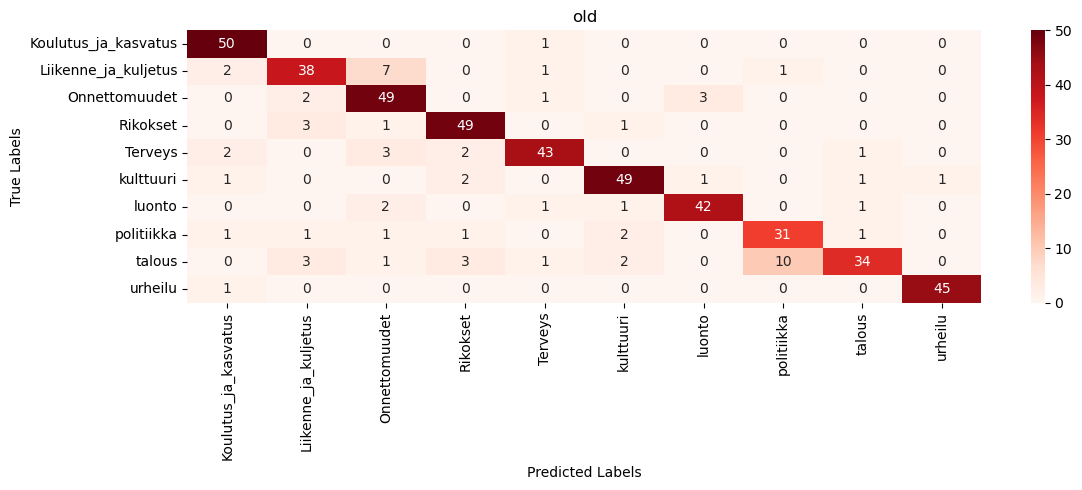

old
                      precision    recall  f1-score   support

Koulutus_ja_kasvatus       0.88      0.98      0.93        51
Liikenne_ja_kuljetus       0.81      0.78      0.79        49
       Onnettomuudet       0.77      0.89      0.82        55
            Rikokset       0.86      0.91      0.88        54
             Terveys       0.90      0.84      0.87        51
           kulttuuri       0.89      0.89      0.89        55
              luonto       0.91      0.89      0.90        47
          politiikka       0.74      0.82      0.78        38
              talous       0.89      0.63      0.74        54
             urheilu       0.98      0.98      0.98        46

            accuracy                           0.86       500
           macro avg       0.86      0.86      0.86       500
        weighted avg       0.86      0.86      0.86       500



In [58]:

print(list(label_mapping.keys()))
# Compute confusion matri
cm = confusion_matrix(correct_labels, prediction_labels,labels=list(label_mapping.keys()))
# cm_modern = confusion_matrix(correct_labels_modern, predictions_modern)

# labl = ["Koulutus_ja_kasvatus", "Liikenne_ja_kuljetus", "Rikokset", "kulttuuri", "luonto", "politiikka", "talous"]


# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(12, 5))

# Plot the first confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',  xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), ax=axes)
axes.set_xlabel("Predicted Labels")
axes.set_ylabel("True Labels")
axes.set_title("old")

# Plot the second confusion matrix
# sns.heatmap(cm_modern, annot=True, fmt='d', cmap='Blues', xticklabels=labl, yticklabels=labl, ax=axes[1])
# axes[1].set_xlabel("Predicted Labels")
# axes[1].set_ylabel("True Labels")
# axes[1].set_title("Modern")

# Adjust layout
plt.tight_layout()
plt.show()

print("old")
print(classification_report(correct_labels, prediction_labels))
# print("modern")
# # print(classification_report(correct_labels_modern, predictions_modern))


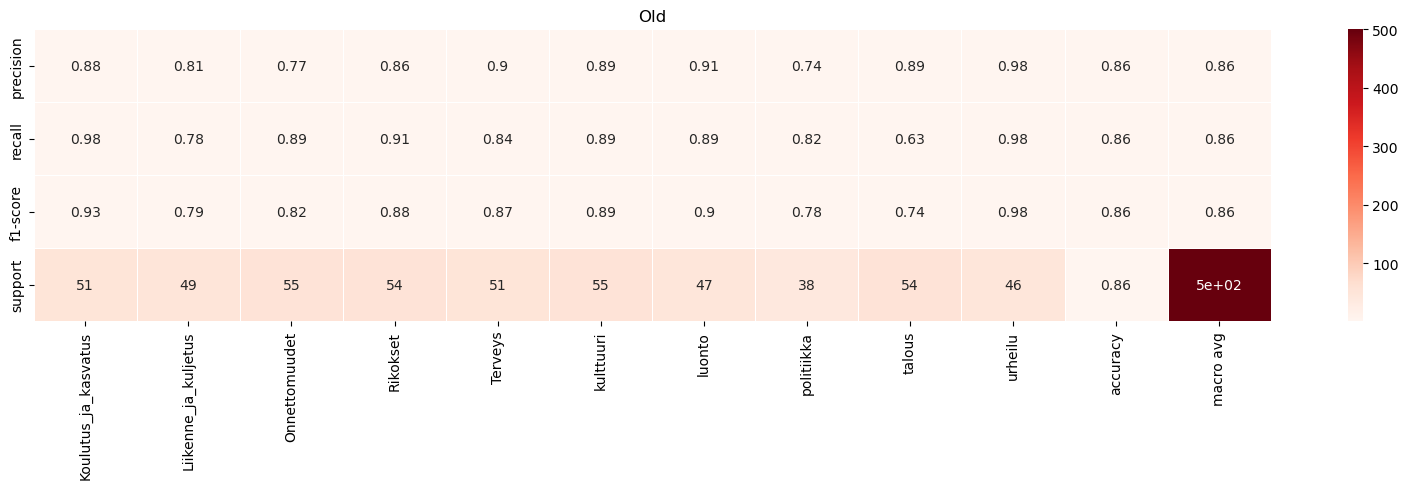

In [59]:
report = classification_report(correct_labels, prediction_labels, output_dict=True)
# report_modern = classification_report(correct_labels_modern, predictions_modern, output_dict=True)


df_report = pd.DataFrame(report).transpose()
# df_report_modern = pd.DataFrame(report_modern).transpose()

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(16, 5))

# Plot the first classification report
sns.heatmap(df_report.iloc[:-1, :].T, annot=True, cmap="Reds", linewidths=0.5, ax=axes)
axes.set_title("Old")

# # Plot the second classification report
# sns.heatmap(df_report_modern.iloc[:-1, :].T, annot=True, cmap="coolwarm", linewidths=0.5, ax=axes[1])
# axes[1].set_title("Modern")

# Adjust layout
plt.tight_layout()
plt.show()

In [60]:
trainer.evaluate(tokenized_datasets["test"])



  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.7985827922821045,
 'eval_accuracy': 0.86,
 'eval_f1': 0.8582027377922807,
 'eval_runtime': 152.7568,
 'eval_samples_per_second': 3.273,
 'eval_steps_per_second': 0.209,
 'epoch': 5.0}

In [61]:
# Loading dataset
test_corpus_data = "test_corpus_data.csv" # 63 dokumenttia
df_corpus = pd.read_csv(test_corpus_data, sep="|")

df_corpus.head(3)


,text_modernized,text_better_ocr,labels,no_ocr_errors
0,Kuulumiset ulkomailta ovat olleet hyvin vähäis...,Kuulumiset ulkomailta owat olleet hywin wähäi-...,Rikokset,Kuulumiset ulkomailta owat olleet hywin wähäis...
1,"Amerikasta kerrotaan, että New Yorkiin, Amerik...","Amerikasta kerrotaan, että NewYork'iin Amerika...",Liikenne_ja_kuljetus,"Amerikasta kerrotaan, että NewYork’iin, Amerik..."
2,Kurmijärveltä kirjoitetaan meille joulukuun lo...,Kurmijärweltä kirjoitetaan meille lopulla wii-...,Rikokset,Kurmijärweltä kirjoitetaan meille lopulla wiim...


In [62]:
df_corpus['labels'] = df_corpus.labels.map(label_mapping)
print(df_corpus.labels)

df_corpus_modernized = df_corpus.copy()
df_corpus_no_ocr_errors = df_corpus.copy()

df_corpus.rename({'text_better_ocr': 'text'}, axis="columns", inplace=True) # parempi ocr-teksti on kopioitu kansalliskirjaston sivuilta. alkuperäisen datasetin ocr-data on heikkolaatuista 
df_corpus_modernized.rename({'text_modernized': 'text'}, axis="columns", inplace=True)
df_corpus_no_ocr_errors.rename({'no_ocr_errors': 'text'}, axis="columns", inplace=True)



0     3
1     1
2     3
3     7
4     7
     ..
58    7
59    7
60    7
61    6
62    8
Name: labels, Length: 63, dtype: int64


In [63]:
df_corpus = Dataset.from_pandas(df_corpus, preserve_index=False)
df_corpus_modernized = Dataset.from_pandas(df_corpus_modernized, preserve_index=False)
df_corpus_no_ocr_errors = Dataset.from_pandas(df_corpus_no_ocr_errors, preserve_index=False)


In [64]:
tokenized_corpus = df_corpus.map(tokenize_function, batched=True)
tokenized_corpus

tokenized_corpus_modern = df_corpus_modernized.map(tokenize_function, batched=True)
tokenized_corpus_modern


tokenized_corpus_no_ocr_errors = df_corpus_no_ocr_errors.map(tokenize_function, batched=True)
tokenized_corpus_no_ocr_errors


Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Dataset({
    features: ['text_modernized', 'text_better_ocr', 'labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 63
})

In [65]:
predictions_corpus = trainer.predict(test_dataset=tokenized_corpus)
preds_corpus = np.argmax(predictions_corpus.predictions, axis=-1)
print(preds_corpus)
print(predictions_corpus.label_ids)

accuracy = accuracy_score(predictions_corpus.label_ids, preds_corpus)
f1 = f1_score(predictions_corpus.label_ids, preds_corpus, average='weighted')
print("accuracy=" , accuracy, "f1=" , f1)

  0%|          | 0/4 [00:00<?, ?it/s]

[0 5 6 7 7 7 7 7 8 1 5 5 8 5 7 8 5 0 5 8 8 5 5 8 5 5 0 5 7 7 7 5 8 8 0 0 5
 5 8 8 5 3 6 8 8 8 8 3 5 5 1 5 5 3 5 5 5 7 7 7 3 5 5]
[3 1 3 7 7 7 7 7 8 1 1 5 1 7 7 7 8 7 5 8 8 5 1 8 3 3 0 7 7 7 7 7 8 7 0 7 5
 7 8 8 5 8 6 5 8 8 8 7 8 5 1 5 5 1 6 1 8 7 7 7 7 6 8]
accuracy= 0.5555555555555556 f1= 0.5679481405937505


[[ 2  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  1  0  4  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  2  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  1  0]
 [ 0  0  0  0  0  2  1  0  0  0]
 [ 2  0  0  2  0  4  0 12  2  0]
 [ 0  0  0  1  0  4  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0  0]]


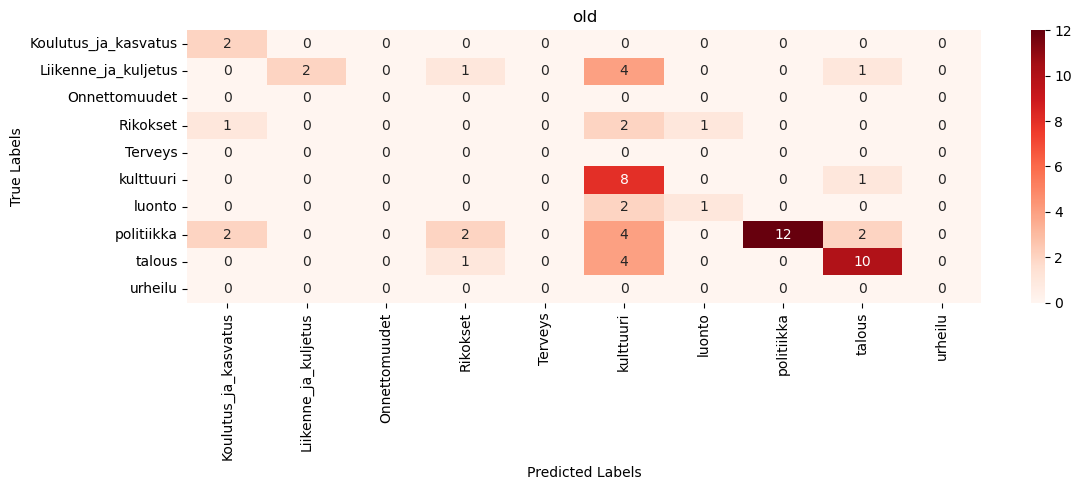

old
                      precision    recall  f1-score   support

Koulutus_ja_kasvatus       0.40      1.00      0.57         2
Liikenne_ja_kuljetus       1.00      0.25      0.40         8
            Rikokset       0.00      0.00      0.00         4
           kulttuuri       0.33      0.89      0.48         9
              luonto       0.50      0.33      0.40         3
          politiikka       1.00      0.55      0.71        22
              talous       0.71      0.67      0.69        15

            accuracy                           0.56        63
           macro avg       0.56      0.53      0.46        63
        weighted avg       0.73      0.56      0.57        63



In [66]:
prediction_labels = [to_labels[x] for x in preds_corpus]
correct_labels = [to_labels[x] for x in predictions_corpus.label_ids]

# Compute confusion matri
cm = confusion_matrix(correct_labels, prediction_labels, labels=list(label_mapping.keys()))
# cm_modern = confusion_matrix(correct_labels_modern, predictions_modern)
print(cm)
# labl = ["Koulutus_ja_kasvatus", "Liikenne_ja_kuljetus", "Rikokset", "kulttuuri", "luonto", "politiikka", "talous"]

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(12, 5))

# labl = ["Koulutus_ja_kasvatus", 
# "Liikenne_ja_kuljetus", 
#             "Rikokset", 
#            "kulttuuri", 
#               "luonto", 
#           "politiikka", 
#               "talous" ]

# Plot the first confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), ax=axes)
axes.set_xlabel("Predicted Labels")
axes.set_ylabel("True Labels")
axes.set_title("old")

# Plot the second confusion matrix
# sns.heatmap(cm_modern, annot=True, fmt='d', cmap='Blues', xticklabels=labl, yticklabels=labl, ax=axes[1])
# axes[1].set_xlabel("Predicted Labels")
# axes[1].set_ylabel("True Labels")
# axes[1].set_title("Modern")

# Adjust layout
plt.tight_layout()
plt.show()

print("old")
print(classification_report(correct_labels, prediction_labels))
# print("modern")
# # print(classification_report(correct_labels_modern, predictions_modern))



In [67]:
predictions_corpus = trainer.predict(test_dataset=tokenized_corpus_modern)
preds_corpus = np.argmax(predictions_corpus.predictions, axis=-1)
print(preds_corpus)
print(predictions_corpus.label_ids)

accuracy = accuracy_score(predictions_corpus.label_ids, preds_corpus)
f1 = f1_score(predictions_corpus.label_ids, preds_corpus, average='weighted')
print("accuracy=" , accuracy, "f1=" , f1)

  0%|          | 0/4 [00:00<?, ?it/s]

[0 1 6 7 7 7 7 7 8 1 5 5 8 3 7 8 8 0 5 8 8 5 1 8 3 3 0 5 7 7 7 5 8 8 0 0 5
 7 8 8 5 3 6 8 8 8 8 5 7 5 1 5 5 1 5 1 1 7 7 7 3 5 5]
[3 1 3 7 7 7 7 7 8 1 1 5 1 7 7 7 8 7 5 8 8 5 1 8 3 3 0 7 7 7 7 7 8 7 0 7 5
 7 8 8 5 8 6 5 8 8 8 7 8 5 1 5 5 1 6 1 8 7 7 7 7 6 8]
accuracy= 0.6825396825396826 f1= 0.689040060468632


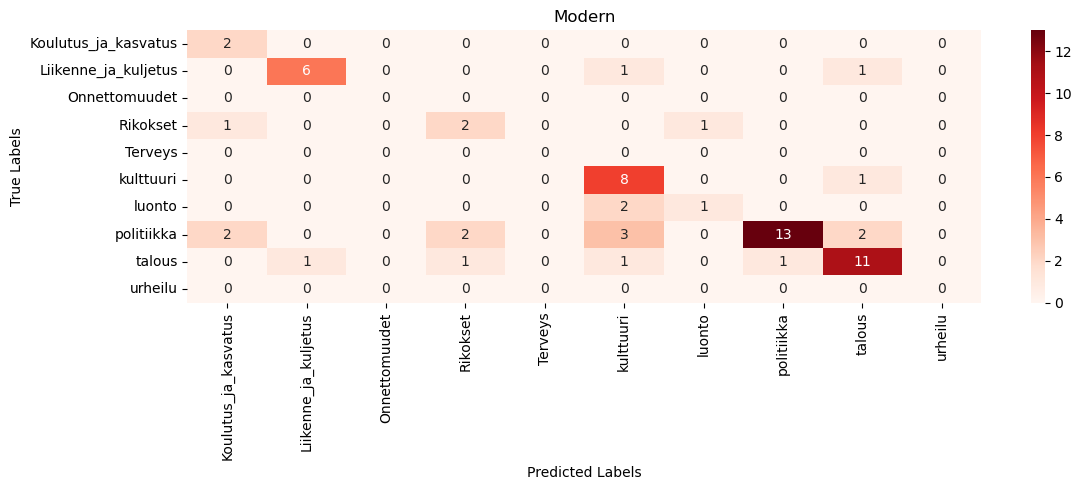

Modern
                      precision    recall  f1-score   support

Koulutus_ja_kasvatus       0.40      1.00      0.57         2
Liikenne_ja_kuljetus       0.86      0.75      0.80         8
            Rikokset       0.40      0.50      0.44         4
           kulttuuri       0.53      0.89      0.67         9
              luonto       0.50      0.33      0.40         3
          politiikka       0.93      0.59      0.72        22
              talous       0.73      0.73      0.73        15

            accuracy                           0.68        63
           macro avg       0.62      0.69      0.62        63
        weighted avg       0.75      0.68      0.69        63



In [68]:
prediction_labels = [to_labels[x] for x in preds_corpus]
correct_labels = [to_labels[x] for x in predictions_corpus.label_ids]


# Compute confusion matri
cm = confusion_matrix(correct_labels, prediction_labels, labels=list(label_mapping.keys()))
# cm_modern = confusion_matrix(correct_labels_modern, predictions_modern)

# labl = ["Koulutus_ja_kasvatus", "Liikenne_ja_kuljetus", "Rikokset", "kulttuuri", "luonto", "politiikka", "talous"]


# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(12, 5))

# Plot the first confusion matrix
# sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',  xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), ax=axes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), ax=axes)

axes.set_xlabel("Predicted Labels")
axes.set_ylabel("True Labels")
axes.set_title("Modern")

# Plot the second confusion matrix
# sns.heatmap(cm_modern, annot=True, fmt='d', cmap='Blues', xticklabels=labl, yticklabels=labl, ax=axes[1])
# axes[1].set_xlabel("Predicted Labels")
# axes[1].set_ylabel("True Labels")
# axes[1].set_title("Modern")

# Adjust layout
plt.tight_layout()
plt.show()

print("Modern")
print(classification_report(correct_labels, prediction_labels))
# print("modern")
# # print(classification_report(correct_labels_modern, predictions_modern))



In [69]:
predictions_corpus = trainer.predict(test_dataset=tokenized_corpus_no_ocr_errors)
preds_corpus = np.argmax(predictions_corpus.predictions, axis=-1)
print(preds_corpus)
print(predictions_corpus.label_ids)

accuracy = accuracy_score(predictions_corpus.label_ids, preds_corpus)
f1 = f1_score(predictions_corpus.label_ids, preds_corpus, average='weighted')
print("accuracy=" , accuracy, "f1=" , f1)

  0%|          | 0/4 [00:00<?, ?it/s]

[0 5 6 7 7 7 7 7 8 1 5 5 8 5 7 8 5 0 5 8 8 5 1 8 5 5 0 5 7 7 7 5 8 8 0 0 5
 5 8 8 5 3 6 8 8 8 8 3 8 5 1 5 5 3 5 5 5 7 7 7 3 5 5]
[3 1 3 7 7 7 7 7 8 1 1 5 1 7 7 7 8 7 5 8 8 5 1 8 3 3 0 7 7 7 7 7 8 7 0 7 5
 7 8 8 5 8 6 5 8 8 8 7 8 5 1 5 5 1 6 1 8 7 7 7 7 6 8]
accuracy= 0.5873015873015873 f1= 0.6012867708178089


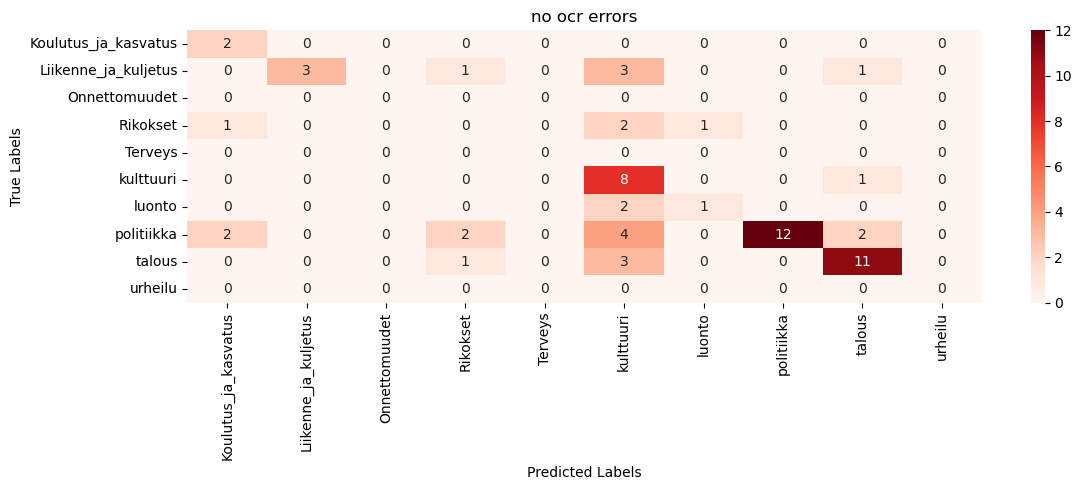

no ocr errors
                      precision    recall  f1-score   support

Koulutus_ja_kasvatus       0.40      1.00      0.57         2
Liikenne_ja_kuljetus       1.00      0.38      0.55         8
            Rikokset       0.00      0.00      0.00         4
           kulttuuri       0.36      0.89      0.52         9
              luonto       0.50      0.33      0.40         3
          politiikka       1.00      0.55      0.71        22
              talous       0.73      0.73      0.73        15

            accuracy                           0.59        63
           macro avg       0.57      0.55      0.50        63
        weighted avg       0.74      0.59      0.60        63



In [70]:
prediction_labels = [to_labels[x] for x in preds_corpus]
correct_labels = [to_labels[x] for x in predictions_corpus.label_ids]


# Compute confusion matri
cm = confusion_matrix(correct_labels, prediction_labels, labels=list(label_mapping.keys()))
# cm_modern = confusion_matrix(correct_labels_modern, predictions_modern)

# labl = ["Koulutus_ja_kasvatus", "Liikenne_ja_kuljetus", "Rikokset", "kulttuuri", "luonto", "politiikka", "talous"]


# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(12, 5))

# Plot the first confusion matrix
# sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',  xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), ax=axes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), ax=axes)

axes.set_xlabel("Predicted Labels")
axes.set_ylabel("True Labels")
axes.set_title("no ocr errors")

# Plot the second confusion matrix
# sns.heatmap(cm_modern, annot=True, fmt='d', cmap='Blues', xticklabels=labl, yticklabels=labl, ax=axes[1])
# axes[1].set_xlabel("Predicted Labels")
# axes[1].set_ylabel("True Labels")
# axes[1].set_title("Modern")

# Adjust layout
plt.tight_layout()
plt.show()

print("no ocr errors")
print(classification_report(correct_labels, prediction_labels))
# print("modern")
# # print(classification_report(correct_labels_modern, predictions_modern))



In [72]:
print(predictions_corpus.predictions)

[[ 7.4073653  -0.9413326  -0.93854266 -0.7951292   0.9876018   0.07978889
  -1.1920443  -1.4446205  -0.80813366 -1.3061571 ]
 [-0.4854538  -0.9578487  -0.4260117  -0.10544846 -1.2500975   4.6915083
   1.720745   -0.89819455 -0.5047091  -1.0831046 ]
 [-1.5128031  -1.1574777  -1.0617324  -0.82975715 -1.153863    0.30088836
   7.1557145  -1.5577518  -0.42658982  0.0152746 ]
 [-1.5814191  -1.1692575  -0.82406557 -0.64613116 -1.1032588  -0.9943103
  -1.0132443   6.0489273   3.4397652  -1.4624459 ]
 [-0.69439346 -1.3263158  -1.2898469   0.35887644 -0.8624885   0.36435178
  -1.4628322   5.140086    2.407093   -1.2693375 ]
 [-1.2551212  -1.0438036  -1.2065111  -0.31255624 -0.7414992  -1.1158756
  -0.9260663   6.891705    1.5985086  -1.5166321 ]
 [-1.2184819  -1.0819393  -0.697409   -0.64083457 -0.8517574  -1.1620467
  -0.86043614  7.1003375   1.2969927  -1.1898031 ]
 [-1.2004789  -1.1416708  -1.0823618   0.22049916 -0.9390127  -0.88565904
  -0.8803054   6.152004    2.170701   -1.5519891 ]
 [-1

In [71]:
model_save_path = "./t_model"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)


('./t_model\\tokenizer_config.json',
 './t_model\\special_tokens_map.json',
 './t_model\\vocab.txt',
 './t_model\\added_tokens.json',
 './t_model\\tokenizer.json')